Contents:
1. <a href=#data_dir>Set working dir and Clone from git hub(for first time)</a><br>
2. <a href=#data_pipeline>Data Pipeline</a><br>
3. <a href=#train>Train</a><br>
4. <a href=#results>Results</a>
5. <a href=#viz_differences>Visualizing Prediction differences at different softmaxes</a><br>
6. <a href=#viz_good_bad>Visualizing highly confidenct correct and incorrect predictions</a><br>


In [0]:
%tensorflow_version 1.x
import numpy as np

import tensorflow as tf

import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm


import tensorflow.contrib.eager as tfe
tf.enable_eager_execution()

<a name=data_dir></a>

# Data Directory Set Up. 
Clone from git if running for first time. Else git pull

In [3]:
import os
os.getcwd()
from google.colab import drive
import os
drive.mount('/content/gdrive')

#IF YOU ARE CLONING FOR THE FIRST TIME in colab please uncomment all the below 5 lines of code. 
#Put git user name and password in appropriate places

#root_path = 'gdrive/My Drive/Colab Notebooks/' #change dir to folder where you want to clone
#os.chdir('/content/' + root_path)
#!git clone https://<UR_GIT_USERNAME>:<GIT_PASSWORD>@github.com/selfishhari/eva_research_team4.git
#!git branch -r | grep -v '\->' | while read remote; do git branch --track "${remote#origin/}" "$remote"; done
#!git checkout zeedense


root_path = 'gdrive/My Drive/Colab Notebooks/eva_research_team4/src/' #change dir to your project folder's src

os.chdir('/content/' + root_path)
os.getcwd()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'/content/gdrive/My Drive/Colab Notebooks/eva_research_team4/src'

In [4]:
!git branch
#YOU NEED TO BE ON "zeedense" branch

  augmentation
  densenext
  development
  master
  tfrecords_fix
* zeedense


In [5]:
!git pull

remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 21 (delta 4), reused 15 (delta 3), pack-reused 0
Unpacking objects: 100% (21/21), done.
From https://github.com/selfishhari/eva_research_team4
   ec22d87..3fc383d  zeedense   -> origin/zeedense
Updating ec22d87..3fc383d
Fast-forward
 .../zeedense_7M_cutout_64_128_x_axis_84_1.ipynb    | 1365 +++++++++
 .../zeedense_7M_cutout_64_1z_cha_axis_92_va.ipynb  | 1483 ++++++++++
 .../zeedense_7M_cutout_64_1z_xaxis_91_2.ipynb      | 3080 ++++++++++++++++++++
 notebooks/zeedense_acc_test_96%_va.ipynb           | 1280 ++++++++
 src/model_blocks.py                                |   16 +-
 src/test_run_script.py                             |    8 +-
 src/zeedensenet.py                                 |    9 +-
 7 files changed, 7235 insertions(+), 6 deletions(-)
 create mode 100644 notebooks/zeedense_7M_cutout_64_128_x_axis_84_1.ipynb
 create mode 100644

In [6]:
#from all_models import DavidNet


import run_util


from importlib import reload
reload(run_util)

from run_util import Run

import data_pipeline

reload(data_pipeline)

from zeedensenet import ZeeDenseNet

from augmentation_utils import cutout

Using TensorFlow backend.



32 conv0.8042321951128099 (3, 3) (1, 1) same (1, 1) None glorot_uniform
32 conv0.8042321951128099 (3, 3) (1, 1) same (1, 1) None glorot_uniform
32 conv0.8042321951128099 (3, 3) (1, 1) same (1, 1) None glorot_uniform


<a name=data_pipeline></a>

# Data Pipeline

In [0]:
data_pipeline.get_data(dataset_name = "CIFAR10", tfrecords_flag=True)

######

In [0]:
train_mean = np.array([125.30691805, 122.95039414, 113.86538318])

train_std= np.array([62.99321928, 62.08870764, 66.70489964])

normalize = lambda x: ((x - train_mean) / train_std)

def data_aug_train(x, y):
    
    #x = tf.image.per_image_standardization(x)
    
    x = normalize(x)
        
    #x = tf.image.random_flip_left_right(x)
    
    paddings = [(4, 4), (4, 4), (0, 0)]
    
    x = tf.pad(x, paddings, "REFLECT")
    
    x = tf.random_crop(x, [32, 32, 3])

    x = tf.image.random_flip_left_right(x)

    x = cutout(x)
    
    return (x, y)
  
def data_aug_test(x, y):
    
    #x = tf.image.per_image_standardization(x)
    
    x = normalize(x)
        
    #x = tf.image.random_flip_left_right(x)
    
    #paddings = [(4, 4), (4, 4), (0, 0)]
    
    #x = tf.pad(x, paddings, "REFLECT")
    
    #x = tf.random_crop(x, [32, 32, 3])
    
    return (x, y)

<a name=train></a>

# Train

In [0]:
obj = Run()

In [0]:
BATCH_SIZE = 256 #@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}

MIN_MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 14 #@param {type:"integer"}
HIGHEST_LR_EPOCH = 5#@param {type:"integer"}


MIN_LEARNING_RATE = 0.000001 #@param {type:"number"}

END_LR_SMOOTHING_PERC = 0.15 #@param {type:"number"}

COMMENTS = "Zeedensenet multisoftmax, gap on channels, multi_inference df" #@param {type:"string"}


params_tune = {
    
  "epochs":EPOCHS, 
 
  "batch_size" : BATCH_SIZE,

  "max_lr": LEARNING_RATE,

  "min_lr":MIN_LEARNING_RATE,

  "end_anneal_pc":END_LR_SMOOTHING_PERC,

  "max_mom":MOMENTUM,
 
  "min_mom":MIN_MOMENTUM,

  "highest_lr_epoch":HIGHEST_LR_EPOCH,
 
  "wd":WEIGHT_DECAY,
  
  "skip_testing_epochs":0,
    
  "batches_per_epoch":50000//BATCH_SIZE,
    
  "comments":COMMENTS
}

In [0]:
loaded_tfrecs = data_pipeline.load_tfrecords(params_tune["batch_size"])

train_dataset = loaded_tfrecs["train"]

eval_dataset = loaded_tfrecs["eval"]

In [0]:
def tst_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
    
    global eval_dataset
  
    len_test = 10000

    test_set = eval_dataset.map(data_aug_test).batch(batch_size).prefetch(1)
    
    return (test_set, len_test)

def trn_data_supplier(epoch_num):
    
    batch_size = params_tune["batch_size"]
  
    global train_dataset
    
    len_train = 50000

    train_set = train_dataset.map(data_aug_train).batch(batch_size).prefetch(1)
    
    return (train_set, len_train)

In [13]:
#import cProfile
model2 = ZeeDenseNet(f_filter=64,  
                     dimensions_dict= {"dimensions_to_sample":(8,8)}, 
                     gap_mode="channel_axis",
                     layers_filters={0:64},
                    multisoft_list = [0, 1, 2],
                     roots_flag=False,
                     reluz= False, bnz=True, convz=True
                    )
x = obj.run(params_tune, trn_data_supplier, tst_data_supplier, model = model2)

64 0.6119236805909045conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
128 0.8074254971250051conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
128 0.4927070460162434conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
128 0.32018904545608595conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
256 0.7824288740079289conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
256 0.8073801302612166conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
256 0.24806590993712863conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
512 0.36784846417794403conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
512 0.7863683279679303conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
512 0.685765534849598conv (3, 3) (1, 1) same (1, 1) None glorot_uniform
64 0.5712089723386752conv (3, 3) (1, 1) same (2, 2) None glorot_uniform


epoch: 1 lr: 0.13333333333333333 train loss: 2.667 train acc:0.432 val loss: 2.243 val acc: 0.536 time:241.032
epoch: 2 lr: 0.26666666666666666 train loss: 1.759 train acc:0.642 val loss: 1.807 val acc: 0.656 time:472.568
epoch: 3 lr: 0.4 train loss: 1.373 train acc:0.728 val loss: 2.229 val acc: 0.604 time:704.900
epoch: 4 lr: 0.35500000000000004 train loss: 1.093 train acc:0.790 val loss: 1.324 val acc: 0.742 time:938.075
epoch: 5 lr: 0.31000000000000005 train loss: 0.930 train acc:0.826 val loss: 1.167 val acc: 0.779 time:1170.883
epoch: 6 lr: 0.265 train loss: 0.823 train acc:0.850 val loss: 1.081 val acc: 0.794 time:1403.526
epoch: 7 lr: 0.22000000000000003 train loss: 0.733 train acc:0.868 val loss: 0.793 val acc: 0.858 time:1638.179
epoch: 8 lr: 0.17500000000000004 train loss: 0.654 train acc:0.887 val loss: 0.683 val acc: 0.882 time:1869.319
epoch: 9 lr: 0.13 train loss: 0.580 train acc:0.903 val loss: 0.612 val acc: 0.898 time:2100.046
epoch: 10 lr: 0.08500000000000002 train l

<a name=results></a>

# Results

In [14]:
early_inf_df = run_util.early_inference_accuracy(obj.model,test_dataset = tst_data_supplier)

early_inf_df

,sm_level,accuracy,loss,inference_time
0,sm1,0.562760,0.8080,0.000278
1,sm2,0.307269,0.8984,0.000626
2,sm3,0.287829,0.9088,0.001343


In [0]:
import visual_utils
reload(visual_utils)
#diff_df = visual_utils.grab_different_imgs(obj.model, trn_data_supplier)

all_df = visual_utils.grab_different_imgs(obj.model, trn_data_supplier, difference=False)

class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
diff_df = all_df

diff_df["subset_diff"] = False

diff_df["subset_diff"] = (diff_df["subset_diff"]) | (diff_df.sm1_correct != diff_df.sm3_correct)

diff_df["subset_diff"] = (diff_df["subset_diff"]) | (diff_df.sm2_correct != diff_df.sm3_correct)

diff_df = diff_df.loc[diff_df.subset_diff==True,:].copy()

In [16]:
all_df.head(3)

,ys,subset,sm3_class,sm3_probs,sm3_correct,sm1_probs,sm1_class,sm1_correct,sm2_probs,sm2_class,sm2_correct,imgs,subset_diff
0,2,True,2,0.987025,True,0.705030,2,True,0.979539,2,True,"[[[-1.7352172, -1.7225418, -1.5570878], [-1.65...",False
1,2,True,2,0.999965,True,0.861142,2,True,0.997234,2,True,"[[[1.8683454, 1.9496236, 2.05584], [2.0429673,...",False
2,1,True,1,1.000000,True,0.907270,1,True,0.999648,1,True,"[[[0.97936076, 1.1926421, 1.381227], [1.058734...",False


Final confusion matrix-at softmax3


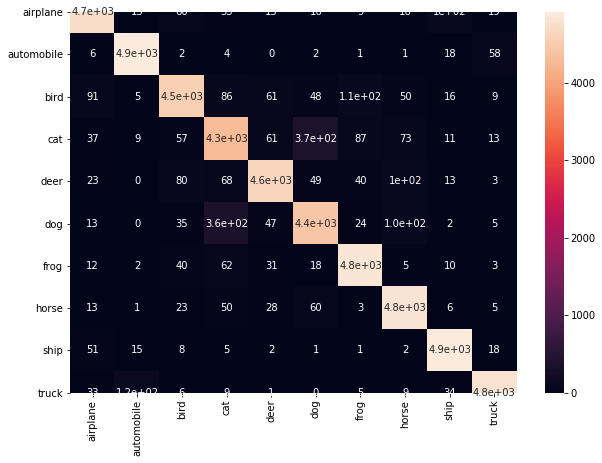

In [17]:
print("Final confusion matrix-at softmax3")
visual_utils.plot_cm(all_df.ys, all_df.sm3_class)

Confusion matrix-at softmax1


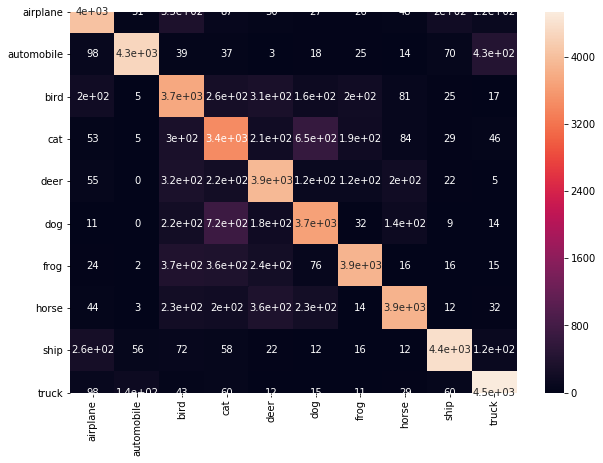

In [18]:
print("Confusion matrix-at softmax1")
visual_utils.plot_cm(all_df.ys, all_df.sm1_class)

Confusion matrix-at softmax2


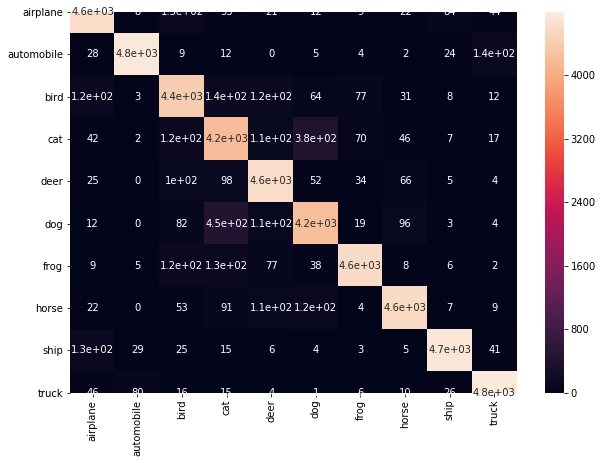

In [19]:
print("Confusion matrix-at softmax2")
visual_utils.plot_cm(all_df.ys, all_df.sm2_class)

**Voting accuracy**

In [20]:
print("Accuracy calculated by voting results from 3 softmaxes.\n \
Mode of predicted class is taken, if all3 are different then the last softmax prediction is taken\n")
run_util.voting_accuracy(df=all_df, true_col="ys", sm_class_colnames = ["sm1_class", "sm2_class", "sm3_class"])

Accuracy calculated by voting results from 3 softmaxes.
 Mode of predicted class is taken, if all3 are different then the last softmax prediction is taken



0.92332

<a name=viz_differences></a>

# Visualizing Images. Difference b/w softmax1 and softmax3

This set of viz has images with the following property

1. All images where softmax1 is doing incorrectly but softmax3 is correct
2. All images where softmax1 is doing correctly but softmax3 is not



These are plotted one next to other for each class

In [0]:
print("last softmax is softmax3, considered softmax is softmax1\n\
predicted1 and prob1-softmax1\n\
predicted2 and prob2-softmax2\n\
predicted3 and prob3-softmax3\n\
")
visual_utils.plot_diff(diff_df, sm_col="sm1_correct", main_col="sm3_correct",
                       denormalize=True, ncols=20)

# Visualizing Images. Difference b/w softmax2 and softmax3

This set of viz has images with the following property

1. All images where softmax2 is doing incorrectly but softmax3 is correct
2. All images where softmax2 is doing correctly but softmax3 is not



These are plotted one next to other for each class

In [0]:
print("last softmax is softmax3, considered softmax is softmax2\n\
predicted1 and prob1-softmax1\n\
predicted2 and prob2-softmax2\n\
predicted3 and prob3-softmax3\n\
")

visual_utils.plot_diff(diff_df,
                       sm_col="sm2_correct", main_col="sm3_correct",
                       img_col="imgs",
              true_col="ys", 
              ncols=10,
              denormalize=True)

<a name=viz_good_bad></a>

# Good and Worse Predictions
In this set of viz, images have following properties

1. For a given softmax, predictions that are both correct and have high probability(Highly confident correct predictions)

2. For a given softmax, predictions that are highly confident but for a wrong class.

These are plotted row by for each class

In [0]:
!git pull
reload(visual_utils)

**Softmax1- Good and worse predictions**

In [0]:
visual_utils.plot_good_and_worst(df=all_df, sm_col="sm1_correct", sm_class="sm1_class", sm_prob="sm1_probs",
              img_col="imgs",
              true_col="ys", 
              ncols=10,
              denormalize=True,
              CLASSWISE_SELECT_TOP_IMAGES = 10)

**Confusion matrix for softmax1**

In [0]:
visual_utils.plot_cm(all_df.ys, all_df.sm1_class)

**Softmax2- Good and worse predictions**

In [0]:
print("\
predicted1 and prob1-softmax1\n\
predicted2 and prob2-softmax2\n\
predicted3 and prob3-softmax3\n\
")

visual_utils.plot_good_and_worst(df=all_df, sm_col="sm2_correct", sm_class="sm2_class", sm_prob="sm2_probs",
              img_col="imgs",
              true_col="ys", 
              ncols=10,
              denormalize=True,
              CLASSWISE_SELECT_TOP_IMAGES = 10)

**Confusion matrix for softmax2**

In [0]:
visual_utils.plot_cm(all_df.ys, all_df.sm2_class)

# Logs

In [19]:
import pandas as pd

pd.read_csv("../data/run_logger.csv").tail()

,total_model_parameters,epochs,batch_size,max_lr,min_lr,anneal_perc,max_mom,min_mom,time_taken,train_acc,test_acc,wd,train_loss,test_loss,runs,log_time,comments
128,7753792,24,512,0.4,0.000001,0.15,0.9,0.9,1684.865651,0.99144,0.9190,0.0005,0.031434,0.281703,"{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",2019-10-26 09:42:47,"Zeedensenet multisoftmax, gap on channels, mul..."
129,7753792,24,512,0.4,0.000001,0.15,0.9,0.9,1672.543345,0.97480,0.9270,0.0005,0.077110,0.233861,"{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",2019-10-26 10:13:04,"Zeedensenet multisoftmax, gap on channels, mul..."
130,6573120,24,512,0.4,0.000001,0.15,0.9,0.9,1506.610169,0.97014,0.9242,0.0005,0.093151,0.234870,"{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",2019-10-26 10:39:26,"Zeedensenet multisoftmax, gap on channels, mul..."
131,7764288,14,256,0.4,0.000001,0.15,0.9,0.9,2698.666154,0.93652,0.9123,0.0005,0.468918,0.538113,"{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",2019-10-26 12:52:29,"Zeedensenet multisoftmax, gap on channels, mul..."
132,7776448,14,256,0.4,0.000001,0.15,0.9,0.9,3265.721450,0.93866,0.9136,0.0005,0.428544,0.522061,"{'epoch': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ...",2019-10-26 14:46:25,"Zeedensenet multisoftmax, gap on channels, mul..."


In [0]:
obj.model.summary()